In [1]:
import os
import time
import math
import argparse 
import natsort

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection
import sklearn.preprocessing as pre
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, BatchSampler, RandomSampler
from torch.autograd import Variable
import matplotlib.pyplot as plt
import sklearn.metrics as met

In [2]:
torch.cuda.get_device_name(0)
use_cuda = torch.cuda.is_available()
print(use_cuda)

device = torch.device('cuda:0' if use_cuda else 'cpu')
# device = torch.device('cpu')
print('학습 기기:',device)

True
학습 기기: cuda:0


In [37]:
data = pd.read_csv('GPS_concat.csv').iloc[10000:15000,2::]
data

C:\Users\JS\.conda\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28,32,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,coll_dt,coll_sqnc,hdr_sqnc,ss_num,nano_ss_num,ins_ss_num,ins_nano_ss_num,src_cont,gps_stts_cd,gps_srvc_dvsn_cd,...,w_axis_drct,drct_covar_val,x_axis_angl_sped,y_axis_angl_sped,z_axis_angl_sped,angl_sped_covar_val,x_axis_linr_acrat,y_axis_linr_acrat,z_axis_linr_acrat,linr_acrat_covar_val
10000,2021-11-11-14-16-08,0.0,13160.0,1.636608e+09,480836329.0,1.636608e+09,609999895.0,ins,4.0,1.0,...,0.135756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.00887,0.00657,0.00609,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.0044,-0.0374,9.7568,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10001,2021-11-11-14-16-08,0.0,13161.0,1.636608e+09,480836329.0,1.636608e+09,609999895.0,ins,4.0,1.0,...,0.135734,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01544,0.00964,-0.00447,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.1602,0.2018,10.1967,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10002,2021-11-11-14-16-08,0.0,13162.0,1.636608e+09,480836329.0,1.636608e+09,609999895.0,ins,4.0,1.0,...,0.135707,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.02319,0.00130,-0.00542,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.0836,0.3201,9.8060,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10003,2021-11-11-14-16-08,0.0,13163.0,1.636608e+09,480836329.0,1.636608e+09,609999895.0,ins,4.0,1.0,...,0.135737,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.02254,-0.00486,0.00613,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.1805,-0.0070,9.5206,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10004,2021-11-11-14-16-08,0.0,13164.0,1.636608e+09,480836329.0,1.636608e+09,609999895.0,ins,4.0,1.0,...,0.135750,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.02015,0.00797,0.00267,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0947,0.1545,9.7819,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2021-11-11-14-16-08,0.0,18155.0,1.636608e+09,381321244.0,1.636608e+09,509999990.0,ins,4.0,1.0,...,0.308280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.02539,-0.00991,0.00833,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.1113,0.4364,11.1357,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
14996,2021-11-11-14-16-08,0.0,18156.0,1.636608e+09,381321244.0,1.636608e+09,509999990.0,ins,4.0,1.0,...,0.308339,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.00619,-0.03031,0.01431,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.4149,0.4400,10.8543,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
14997,2021-11-11-14-16-08,0.0,18157.0,1.636608e+09,381321244.0,1.636608e+09,509999990.0,ins,4.0,1.0,...,0.308382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.01275,-0.03222,0.01200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.3588,0.4128,10.1948,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
14998,2021-11-11-14-16-08,0.0,18158.0,1.636608e+09,381321244.0,1.636608e+09,509999990.0,ins,4.0,1.0,...,0.308432,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.01661,-0.03849,0.01296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.2899,0.2051,10.2292,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


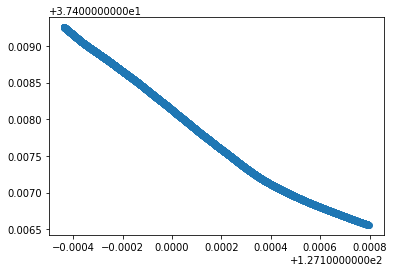

In [4]:
plt.scatter(data.loc[:,['longitude']].values,data.loc[:,['latitude']].values)

In [5]:
window = 50

data2 = data.loc[:,['longitude','latitude']]
inputdata = data.loc[:,['twst_linr_x_crdn','twst_linr_y_crdn', #'twst_linr_z_crdn', 
                        'x_axis_drct','y_axis_drct', #'z_axis_drct',
                        #'x_axis_angl_sped', 'y_axis_angl_sped',# 'z_axis_angl_sped',
        'x_axis_linr_acrat', 'y_axis_linr_acrat'#,'z_axis_linr_acrat'
                       ]]

scaler = pre.MinMaxScaler()
inputdata1 = scaler.fit_transform(inputdata)

                   twst_linr_x_crdn  twst_linr_y_crdn  x_axis_drct  \
twst_linr_x_crdn           1.000000          0.810209     0.462422   
twst_linr_y_crdn           0.810209          1.000000     0.504665   
x_axis_drct                0.462422          0.504665     1.000000   
y_axis_drct                0.481205         -0.023044     0.307489   
x_axis_linr_acrat          0.381492          0.285587     0.471669   
y_axis_linr_acrat          0.173813         -0.188131     0.043916   

                   y_axis_drct  x_axis_linr_acrat  y_axis_linr_acrat  
twst_linr_x_crdn      0.481205           0.381492           0.173813  
twst_linr_y_crdn     -0.023044           0.285587          -0.188131  
x_axis_drct           0.307489           0.471669           0.043916  
y_axis_drct           1.000000           0.342385           0.669370  
x_axis_linr_acrat     0.342385           1.000000           0.096720  
y_axis_linr_acrat     0.669370           0.096720           1.000000  


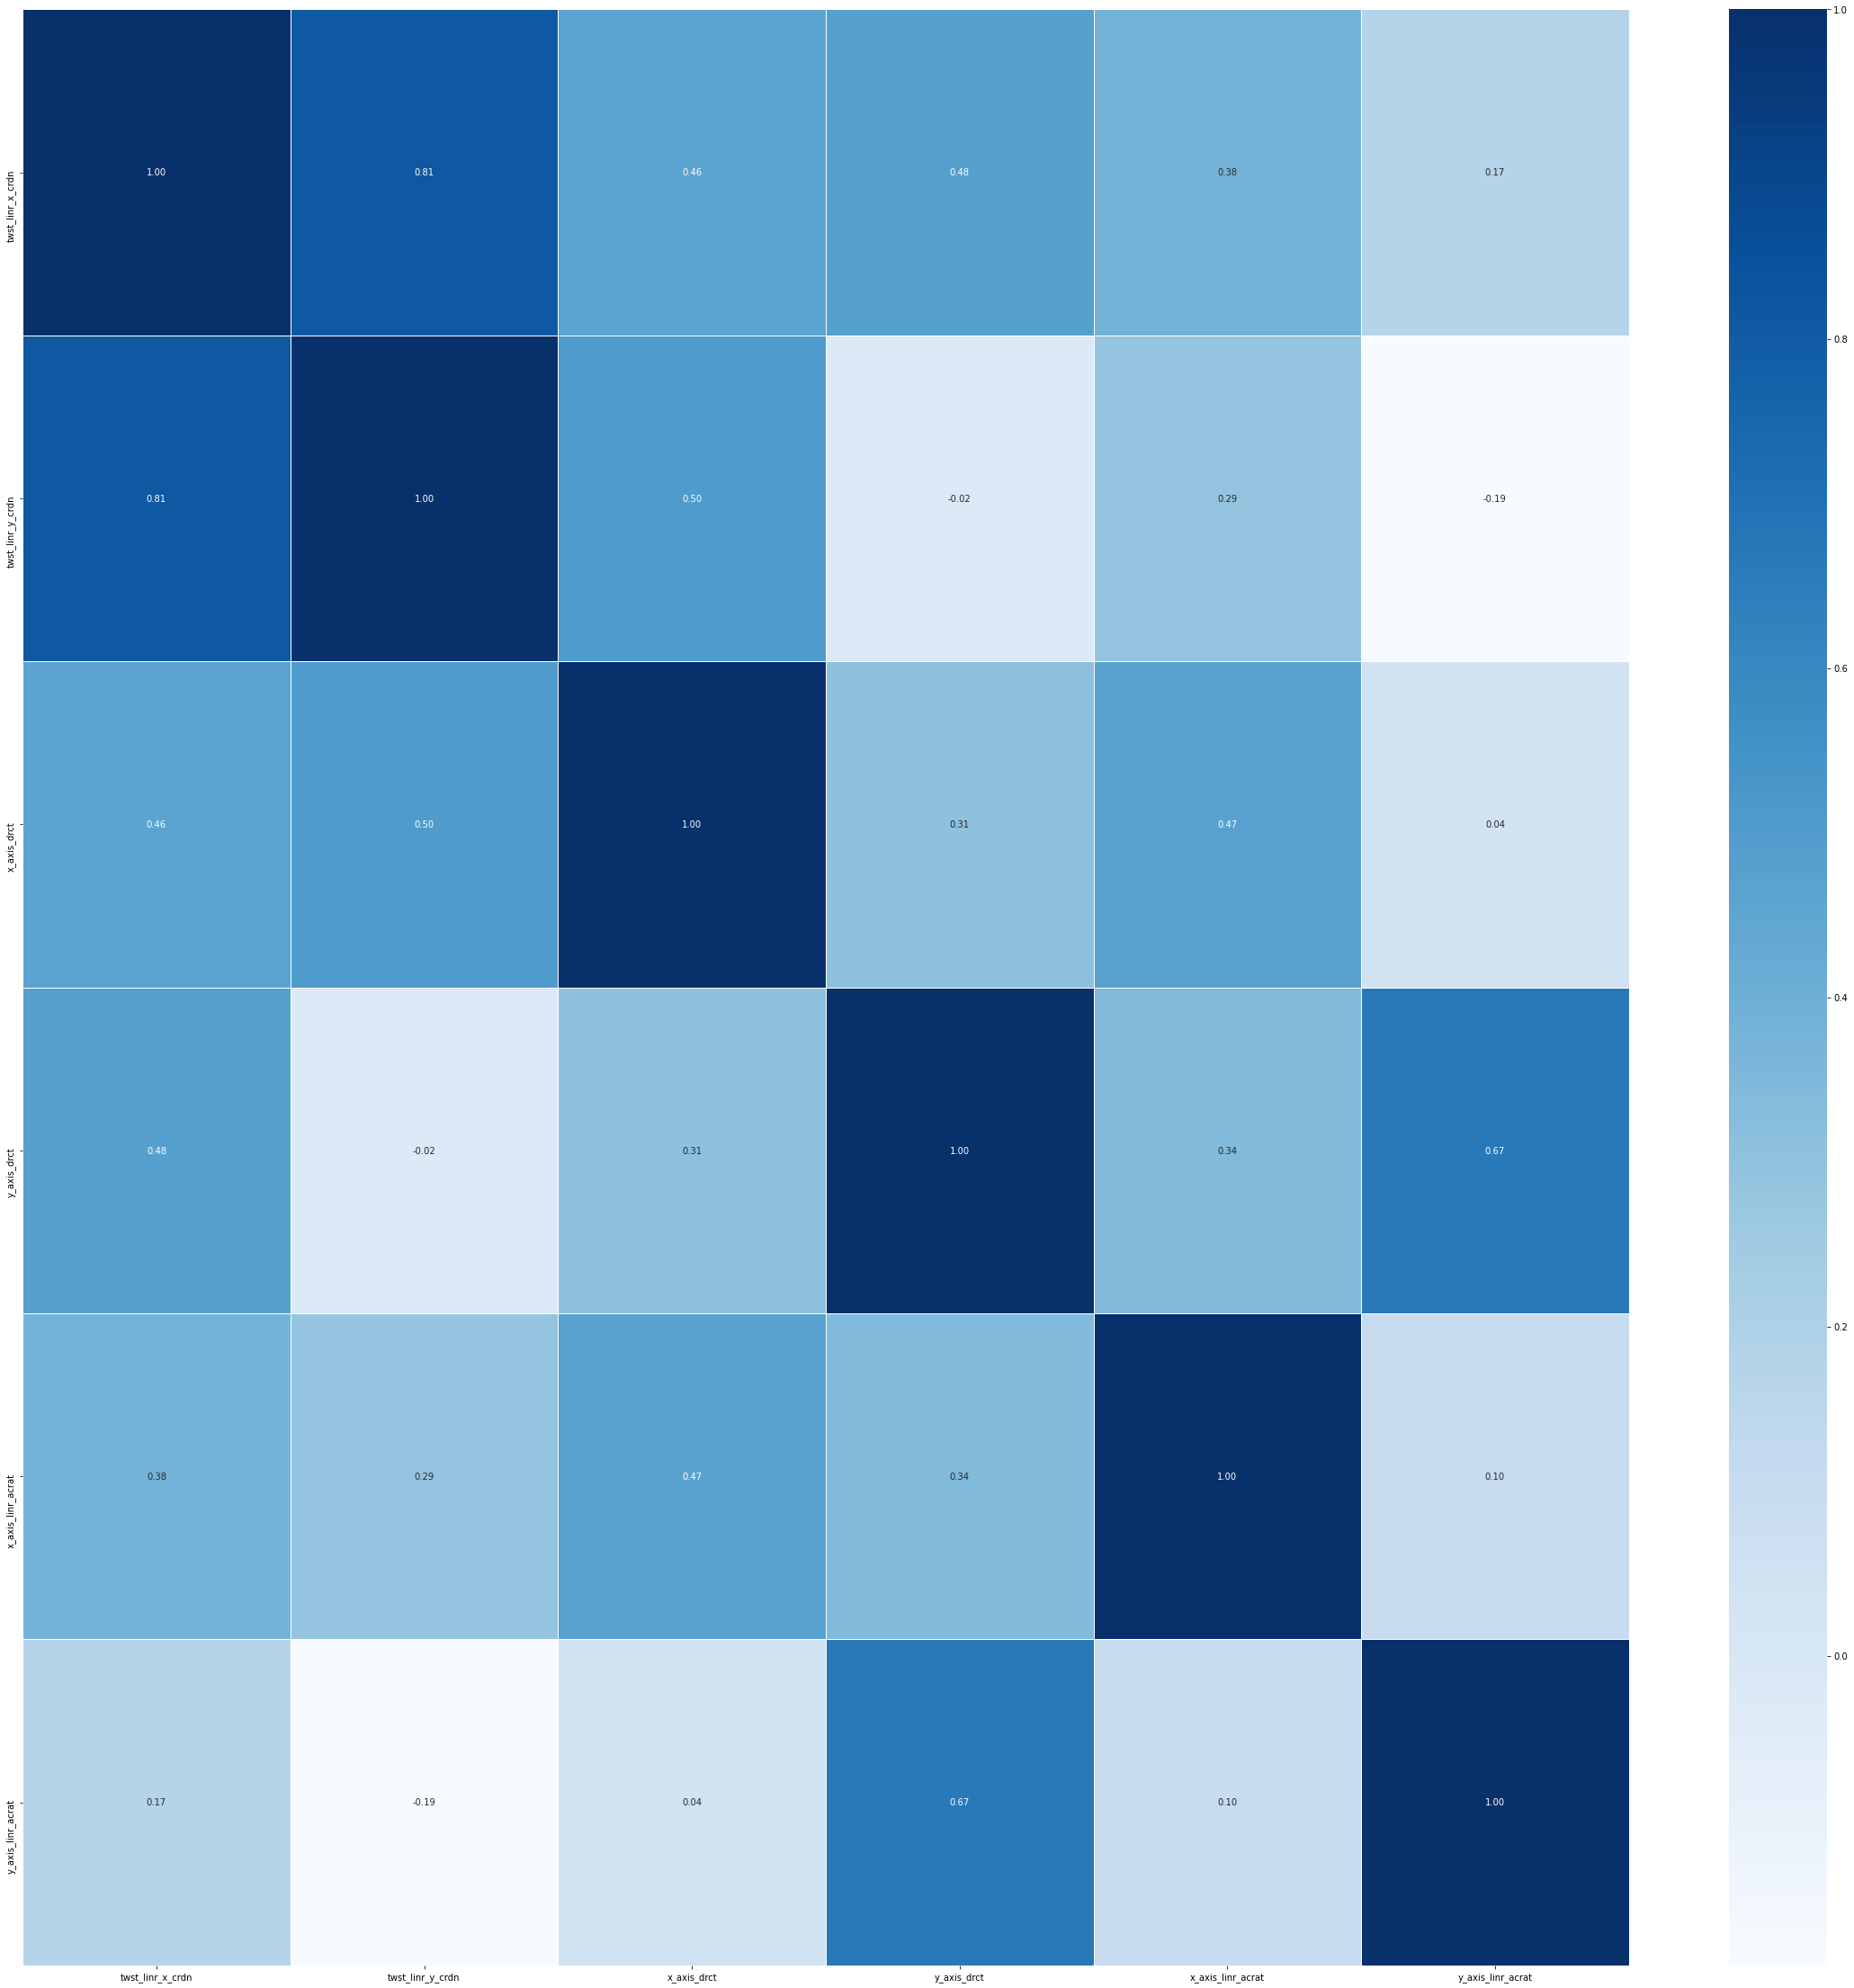

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40,40))
sns.heatmap(data = inputdata.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.savefig('corr')
print(inputdata.corr())

In [7]:
inputdata1

array([[0.01004197, 0.41485228, 0.77075826, 0.19906764, 0.47790917,
        0.49149274],
       [0.00968492, 0.41700922, 0.77365113, 0.19748978, 0.42139437,
        0.55932396],
       [0.00883695, 0.41793341, 0.77477576, 0.19493943, 0.44918021,
        0.59287092],
       ...,
       [0.9988842 , 0.99763785, 0.94869719, 0.5772055 , 0.60965612,
        0.61915835],
       [0.99991072, 0.99897296, 0.93822098, 0.57765785, 0.58466338,
        0.56025975],
       [1.        , 1.        , 0.92903799, 0.57702487, 0.54657574,
        0.61178539]])

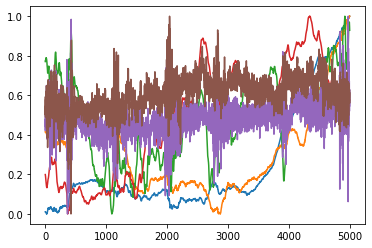

In [39]:
plt.plot(inputdata1)

torch.Size([4951, 2])


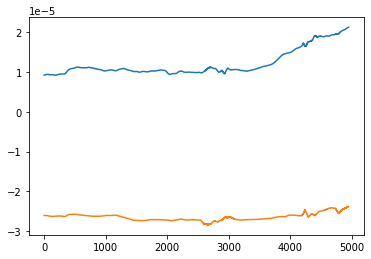

In [9]:
y_data2 = []
for i in range(window-1,len(data2)):
    y_data2.append(data2.iloc[i] - data2.iloc[i-window+1])

y_data2 = torch.tensor(y_data2)
print(y_data2.shape)
plt.plot(y_data2)

y_data2 = scaler.fit_transform(y_data2)

In [10]:
y_data2

array([[0.00144024, 0.51568264],
       [0.00201789, 0.5159318 ],
       [0.00229778, 0.51589535],
       ...,
       [0.99828156, 0.99485862],
       [0.99951143, 0.99964302],
       [1.        , 1.        ]])

In [11]:
inputdata2 = torch.tensor(inputdata1)
x_data = inputdata2.unfold(0,window,1)
x_data2 = x_data.permute(0,2,1)
print(x_data2.shape)

torch.Size([4951, 50, 6])


In [12]:
class make_dataset(Dataset):
    #데이터셋 전처리
    def __init__(self):
        self.input = x_data2
        self.label = y_data2 

    def __getitem__(self, idx):       
        x = self.input[idx]
        y = self.label[idx]
        return x, y
        
    #데이터의 길이(샘플 수) 기입
    def __len__(self):
        return self.input.shape[0]
    
dataset = make_dataset()  

In [13]:
print(len(dataset))

4951


In [14]:
#Random split
split_num = round(len(dataset)*0.8)

train_dataset, test_dataset = random_split(dataset,[split_num,len(dataset)-split_num])
# show_dataset1,show_dataset2 = random_split(dataset,[100,140])
test_loader = DataLoader(test_dataset, shuffle=True)
# train_loader = DataLoader(dataset=train_dataset,batch_size=1,sampler=RandomSampler(train_dataset),drop_last=True)
train_loader = DataLoader(dataset=train_dataset,shuffle=True)
# show_loader = DataLoader(show_dataset1, shuffle = True)
print(len(train_loader))
print(len(test_loader))

3961
990


In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        
        
        self.cnn1 = nn.Conv2d(1,5,(5,6),padding='same')
        self.maxpool1 = nn.MaxPool2d((5,3),stride=1)
        self.cnn2 = nn.Conv2d(5,10,(5,4),padding='same')
        self.cnn3 = nn.Conv2d(10,20,(5,1),padding='same')
        self.maxpool2 = nn.MaxPool2d((5,1),stride=1)

        
        self.act = nn.LeakyReLU()
        
        self.flatten_layer = nn.Flatten()
        
        #fully connected layer     
        self.fc_layers = nn.Sequential(
            nn.Linear(1520,380),
            nn.LeakyReLU(),
            nn.Linear(380,95),
            nn.LeakyReLU(),
            nn.Linear(95,19),
            nn.LeakyReLU(),
            nn.Linear(19,1)
            
        )
#         self.dropout = nn.Dropout(p=0.2)
  
                
    def forward(self,x):
        x = torch.unsqueeze(x,0)
        x = x.permute(1,0,2,3)
        
        out = self.cnn1(x)
        out = self.act(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.act(out)
        out = self.maxpool1(out)
        
        out = self.cnn3(out)
        out = self.act(out)
        out = self.maxpool2(out)
        
        out = self.flatten_layer(out)
        out = self.fc_layers(out)
        return out

In [16]:
model_long = CNN().to(device).float()
model_la = CNN().to(device).float()

In [17]:
learning_rate = 0.01
num_epoch = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model_long.parameters(), lr=1e-6)
optimizer = optim.Adam(model_la.parameters(), lr=1e-6)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)

# chk_callback = ModelCheckpoint(dirpath='./lightning_chks',
#                               filename='HR_to_HAMD-epoch{epoch:02d}-val_loss{val-loss:.2f}',
#                               verbose=True, save_last=True, save_top_k=5, monitor='val_loss',mode='min')
# earlystop_callback = EarlyStopping(monitor='val_loss',patience=5,verbose=True,mode='min')

In [18]:
loss_valid = []
loss_train = []
correct_valid = []

In [19]:
time_init = time.time()
the_last_loss = 100
patience = 3
trigger_times = 0

#여기까지
for epoch in range(num_epoch):
    # train model
    running_loss = 0.
    num_runs = 0
    model_long.train()
    total_length = len(train_loader)
    for iter_idx, data in enumerate(train_loader):
        inputs,label = data
        inputs = inputs.to(device).float()
        label = label[:,0].to(device).float()
                
        output =model_long(inputs)
#         print(str(output)+" vs "+str(label))


        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_runs += 1
        
      

            
    print(f"[Epoch {epoch}] Loss: {running_loss / num_runs}")
    loss_train.append(running_loss/num_runs)

# test model with validation data
    model_long.eval()
    running_loss = 0.
    num_runs = 0
    correct = 0
    preds = []
    labels = []
    subjects = []
    for iter_idx, data in enumerate(test_loader):
        inputs,label = data
        
        inputs = inputs.to(device).float()
        #crossentrophy 사용시
        label = label[:,0].to(device).float()


        output = model_long(inputs)
        loss = criterion(output, label)
        pred = output.argmax(dim=1)
#         print(str(pred)+'&&&'+str(label))
        if pred == label:
            correct += 1
                
        preds.append(output.tolist())
        labels.append(label)
        
        running_loss += loss.item()
        num_runs += 1
      
        
    
            
    print(f"[Validation] Loss: {running_loss / num_runs} Correct: {correct/len(test_loader)}")
    loss_valid.append(running_loss/num_runs)
    correct_valid.append(correct/len(test_loader))

    #Early Stopping
    the_current_loss = running_loss / num_runs
    if the_current_loss > the_last_loss:
        trigger_times += 1
        
    if trigger_times>= patience:
        print('Early stopped')
        break    
    else:
        trigger_times=0
        
    the_last_loss = the_current_loss
            
#             if (running_loss < min_val_loss) or (epoch % 10 == 0):
#                 nsml.save(epoch)

final_time = time.time()
preds_long = preds
print("Time spent on training :",final_time - time_init)

        
print("Done")

C:\Users\JS\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\JS\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\JS\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Ple

[Epoch 0] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 1] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 2] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 3] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 4] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 5] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 6] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 7] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 8] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 9] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 10] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 11] Loss: 0.1555133942474452
[Valid

[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 94] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 95] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 96] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 97] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 98] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
[Epoch 99] Loss: 0.1555133942474452
[Validation] Loss: 0.14882739778464624 Correct: 0.0
Time spent on training : 1029.5499486923218
Done


Text(0, 0.5, 'Loss')

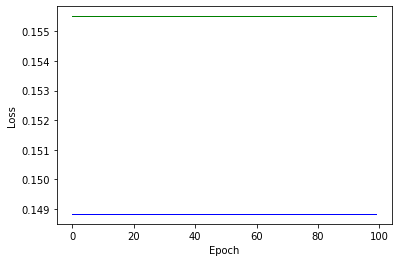

In [20]:
#epoch에 따른 loss 변화 그래프
plt.plot(loss_train,'g',label='Train Loss',linewidth=1)
plt.plot(loss_valid,'b',label='Valid Loss',linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [21]:
time_init = time.time()
the_last_loss = 100
patience = 3
trigger_times = 0

#여기까지
for epoch in range(num_epoch):
    # train model
    running_loss = 0.
    num_runs = 0
    model_la.train()
    total_length = len(train_loader)
    for iter_idx, data in enumerate(train_loader):
        inputs,label = data
        inputs = inputs.to(device).float()
        label = label[:,1].to(device).float()
                
        output =model_la(inputs)


        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_runs += 1
        
      

            
    print(f"[Epoch {epoch}] Loss: {running_loss / num_runs}")
    loss_train.append(running_loss/num_runs)

# test model with validation data
    model_la.eval()
    running_loss = 0.
    num_runs = 0
    correct = 0
    preds = []
    labels = []
    subjects = []
    for iter_idx, data in enumerate(test_loader):
        inputs,label = data
        
        inputs = inputs.to(device).float()
        #crossentrophy 사용시
        label = label[:,1].to(device).float()


        output = model_la(inputs)
        loss = criterion(output, label)
        pred = output.argmax(dim=1)
#         print(str(pred)+'&&&'+str(label))
        if pred == label:
            correct += 1
                
        preds.append(output.tolist())
        labels.append(label)
        
        running_loss += loss.item()
        num_runs += 1
      
        
    
            
    print(f"[Validation] Loss: {running_loss / num_runs} Correct: {correct/len(test_loader)}")
    loss_valid.append(running_loss/num_runs)
    correct_valid.append(correct/len(test_loader))

    #Early Stopping
    the_current_loss = running_loss / num_runs
    if the_current_loss > the_last_loss:
        trigger_times += 1
        
    if trigger_times>= patience:
        print('Early stopped')
        break    
    else:
        trigger_times=0
        
    the_last_loss = the_current_loss
            
#             if (running_loss < min_val_loss) or (epoch % 10 == 0):
#                 nsml.save(epoch)

final_time = time.time()
preds_la = preds
print("Time spent on training :",final_time - time_init)

        
print("Done")

[Epoch 0] Loss: 0.0691986620097016
[Validation] Loss: 0.034181823974680677 Correct: 0.0
[Epoch 1] Loss: 0.03291246971728113
[Validation] Loss: 0.0323581487481605 Correct: 0.0
[Epoch 2] Loss: 0.03157053406837267
[Validation] Loss: 0.031035001469545798 Correct: 0.0
[Epoch 3] Loss: 0.03026625109596438
[Validation] Loss: 0.029647793337410515 Correct: 0.0
[Epoch 4] Loss: 0.028739704776173932
[Validation] Loss: 0.02786826663606186 Correct: 0.0
[Epoch 5] Loss: 0.02677027568613377
[Validation] Loss: 0.025861120509287634 Correct: 0.0
[Epoch 6] Loss: 0.0244055085057053
[Validation] Loss: 0.023127941132281064 Correct: 0.0
[Epoch 7] Loss: 0.021126507664207688
[Validation] Loss: 0.01952768121995535 Correct: 0.0
[Epoch 8] Loss: 0.01743675375050168
[Validation] Loss: 0.01588059757322117 Correct: 0.0
[Epoch 9] Loss: 0.01380900368655573
[Validation] Loss: 0.012237606419755848 Correct: 0.0
[Epoch 10] Loss: 0.010651430786741807
[Validation] Loss: 0.009421857568979957 Correct: 0.0
[Epoch 11] Loss: 0.00832

[Epoch 90] Loss: 0.0025234224969260216
[Validation] Loss: 0.002577868949143411 Correct: 0.0
[Epoch 91] Loss: 0.0025085268905048488
[Validation] Loss: 0.0025138558434069525 Correct: 0.0
[Epoch 92] Loss: 0.002505378016940393
[Validation] Loss: 0.002464317225412445 Correct: 0.0
[Epoch 93] Loss: 0.0024925649882746198
[Validation] Loss: 0.0025290887660944566 Correct: 0.0
[Epoch 94] Loss: 0.0024873883506264702
[Validation] Loss: 0.0024495415791743686 Correct: 0.0
[Epoch 95] Loss: 0.0024699868404705703
[Validation] Loss: 0.0024561575535897934 Correct: 0.0
[Epoch 96] Loss: 0.002460299001247589
[Validation] Loss: 0.0024199795497781298 Correct: 0.0
[Epoch 97] Loss: 0.002453774918247998
[Validation] Loss: 0.0024385888514913833 Correct: 0.0
[Epoch 98] Loss: 0.002439130745532693
[Validation] Loss: 0.0024527117279025037 Correct: 0.0
[Epoch 99] Loss: 0.002431182655159955
[Validation] Loss: 0.002398112713537168 Correct: 0.0
Time spent on training : 1402.2668688297272
Done


Text(0, 0.5, 'Loss')

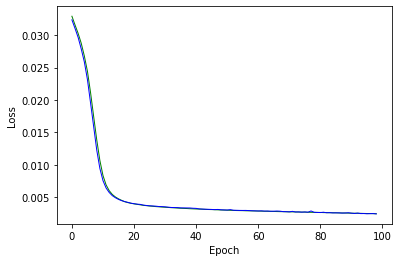

In [24]:
#epoch에 따른 loss 변화 그래프
plt.plot(loss_train[101::],'g',label='Train Loss',linewidth=1)
plt.plot(loss_valid[101::],'b',label='Valid Loss',linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')

MSE Loss : tensor(1.4180e-05, device='cuda:0', grad_fn=<MseLossBackward>)
정확도 : 0.0
990개 데이터 중 0개 맞히고 있음


<ipython-input-36-449657aaffb3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to('cpu')


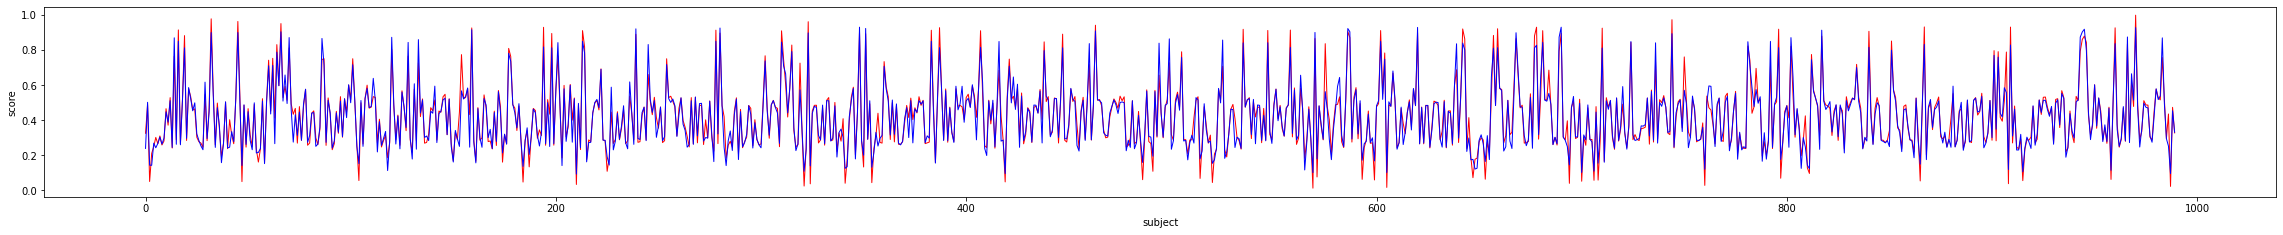

In [36]:
plt.figure(figsize=(40, 3.5))
preds2 = torch.tensor(preds_la).to('cpu').squeeze()
labels = torch.tensor(labels).to('cpu')
plt.plot(labels,'r',label='Actual weight',linewidth=1)
plt.plot(preds2,'b',label='Predicted weight',linewidth=1)
# plt.scatter(range(500),result_pred[0:500],c='yellow',s=10,label='correct')

values = range(len(labels))

plt.xlabel('subject')
plt.ylabel('score')
# plt.xticks(values,subject.values)
# loss = criterion2(preds2,labels)
print('MSE Loss : '+str(loss))
print('정확도 : '+str(correct/len(test_loader)))
print(str(len(test_loader))+"개 데이터 중 "+str(correct)+"개 맞히고 있음")

plt.savefig("result.png")


In [31]:
torch.tensor(preds_la).shape

torch.Size([990, 1, 1])

In [ ]:
path = ''

torch.save(model_long, path + 'model.pt')  # 전체 모델 저장
# torch.save(model.state_dict(), path + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
# torch.save({
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }, path + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [ ]:
model = torch.load(path + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
# model.load_state_dict(torch.load(path + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

# checkpoint = torch.load(path + 'all.tar')   # dict 불러오기
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
print(model)

with torch.no_grad():
    model.eval()
    inputs = 
    outputs = model(inputs)
    print(outputs)